In [3]:
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

from Load_Data import Load_Data
print(tf.__version__)

2.4.1


In [4]:
# 获取数据
merge_dataset = Load_Data()
# 将'Rain'列转换为离散数值
merge_dataset['Rain'] = pd.Categorical(merge_dataset['Rain'])
merge_dataset['Rain'] = merge_dataset.Rain.cat.codes
# 去除空数据
merge_dataset[merge_dataset < - 1000] = np.nan
merge_dataset.dropna(inplace=True)

In [5]:
merge_dataset.columns

Index(['10', 'Tamb(K)', 'Rh(%)', 'Pres(mb)', 'Tir(K)', 'Rain', 'Azim', 'Elev',
       'TkBB(K)', ' 22.235', ' 23.035', ' 23.835', ' 26.235', ' 30.000',
       ' 51.250', ' 52.280', ' 53.850', ' 54.940', ' 56.660', ' 57.290',
       ' 58.800', '0.00', '0.10', '0.20', '0.30', '0.40', '0.50', '0.60',
       '0.70', '0.80', '0.90', '1.00', '1.25', '1.50', '1.75', '2.00', '2.25',
       '2.50', '2.75', '3.00', '3.25', '3.50', '3.75', '4.00', '4.25', '4.50',
       '4.75', '5.00', '5.25', '5.50', '5.75', '6.00', '6.25', '6.50', '6.75',
       '7.00', '7.25', '7.50', '7.75', '8.00', '8.25', '8.50', '8.75', '9.00',
       '9.25', '9.50', '9.75', '10.00'],
      dtype='object')

In [6]:
# 去除['10','Azim', 'Elev']几列
# 温度训练
merge_dataset.drop([
    '10', 'Rain', 'TkBB(K)', 'Rh(%)', 'Pres(mb)', 'Tir(K)', 'Azim', 'Elev',
    ' 22.235', ' 23.035', ' 23.835', ' 26.235', ' 30.000' ,'1.25', '1.50', '1.75', '2.00', '2.25',
       '2.50', '2.75', '3.00', '3.25', '3.50', '3.75', '4.00', '4.25', '4.50',
       '4.75', '5.00', '5.25', '5.50', '5.75', '6.00', '6.25', '6.50', '6.75',
       '7.00', '7.25', '7.50', '7.75', '8.00', '8.25', '8.50', '8.75', '9.00',
       '9.25', '9.50', '9.75', '10.00'], axis=1, inplace=True)

In [7]:
# 保留小数位
merge_dataset = merge_dataset.round(1)
# 归一化
def norm(x):
    return (x - merge_dataset.describe().transpose()['mean']) / merge_dataset.describe().transpose()['std']
merge_dataset.iloc[:, :8] = norm(merge_dataset).iloc[:, :8]

In [8]:
# 乱序，分离训练数据与测试数据
train_data = merge_dataset.sample(frac=0.8, random_state=0)
test_data = merge_dataset.drop(train_data.index)
# 分离标签
train_labels = train_data.iloc[:, 8:]
test_labels = test_data.iloc[:, 8:]
train_data.drop(train_labels.columns, axis=1, inplace=True)
test_data.drop(train_labels.columns, axis=1, inplace=True)
print(train_data.shape, test_data.shape, train_labels.shape, test_labels.shape)

(1137, 8) (284, 8) (1137, 11) (284, 11)


In [9]:
def build_model():
    My_model = keras.Sequential([
        layers.Dense(len(train_data.keys()), activation='relu', input_shape=[len(train_data.keys())]),
        layers.Dense(47, activation='relu'),
        layers.Dense(11)
    ])

    opt = tf.optimizers.Adam(1e-3)
    # tf.train.GradientDescentOptimizer(0.001)
    # tf.keras.optimizers.RMSprop(0.001)
    # tf.optimizers.Adam(1e-3)

    My_model.compile(loss='mse',
                     optimizer=opt,
                     metrics=['mae', 'mse']
                     )
    return My_model
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 47)                423       
_________________________________________________________________
dense_2 (Dense)              (None, 11)                528       
Total params: 1,023
Trainable params: 1,023
Non-trainable params: 0
_________________________________________________________________


In [10]:
history = model.fit(train_data,
                    train_labels,
                    batch_size=32,
                    epochs=2000,
                    verbose=2,
                    validation_split=0.2)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

Epoch 1/2000
29/29 - 3s - loss: 68872.6016 - mae: 262.3315 - mse: 68872.6016 - val_loss: 68445.5781 - val_mae: 261.5057 - val_mse: 68445.5781
Epoch 2/2000
29/29 - 0s - loss: 68618.0078 - mae: 261.8449 - mse: 68618.0078 - val_loss: 68074.8672 - val_mae: 260.7950 - val_mse: 68074.8672
Epoch 3/2000
29/29 - 0s - loss: 68020.5625 - mae: 260.6985 - mse: 68020.5625 - val_loss: 67161.5703 - val_mae: 259.0302 - val_mse: 67161.5703
Epoch 4/2000
29/29 - 0s - loss: 66646.1172 - mae: 258.0314 - mse: 66646.1172 - val_loss: 65162.7266 - val_mae: 255.1053 - val_mse: 65162.7266
Epoch 5/2000
29/29 - 0s - loss: 63889.4375 - mae: 252.5573 - mse: 63889.4375 - val_loss: 61549.7812 - val_mae: 247.7817 - val_mse: 61549.7812
Epoch 6/2000
29/29 - 0s - loss: 59332.7852 - mae: 243.1362 - mse: 59332.7852 - val_loss: 56000.2852 - val_mae: 235.8933 - val_mse: 56000.2852
Epoch 7/2000
29/29 - 0s - loss: 52810.4727 - mae: 228.6694 - mse: 52810.4727 - val_loss: 48703.8242 - val_mae: 218.8403 - val_mse: 48703.8242
Epoch 

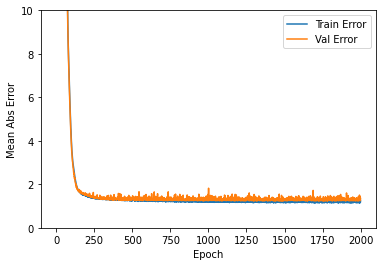

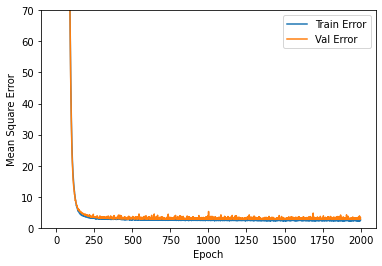

In [11]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(hist['epoch'], hist['mae'],
             label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
             label='Val Error')
    plt.ylim([0, 10])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.plot(hist['epoch'], hist['mse'],
             label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
             label='Val Error')
    plt.ylim([0, 70])
    plt.legend()
    plt.show()
plot_history(history)

In [12]:
loss, mae, mse = model.evaluate(test_data, test_labels, verbose=1)

print("MAE: {:5.2f} ".format(mae))
print("MSE: {:5.2f} ".format(mse))
print("LOSS: {:5.2f} ".format(loss))

9/9 [==============================] - 0s 2ms/step - loss: 2.2976 - mae: 1.1788 - mse: 2.2976
MAE:  1.18 
MSE:  2.30 
LOSS:  2.30 


In [13]:
r1 = 0
for i in range(10):
    r = np.corrcoef(model.predict(test_data[i:i + 1]), test_labels[i:i + 1])
    r1 += r[0, 1]
# print(r1/10)
print('相关系数 {:.4}'.format(r1 / 10))

相关系数 0.9994


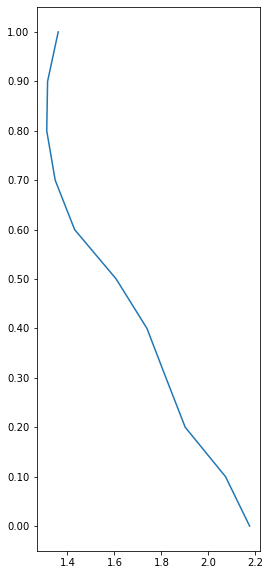

相关系数0.9986
2009/02/18:20    1.6437
dtype: float64


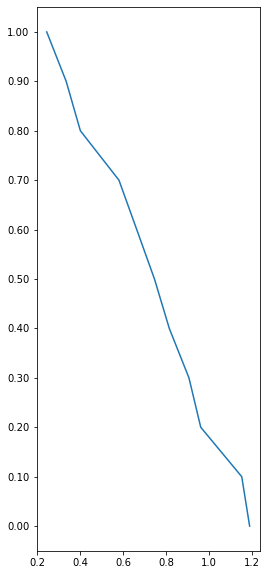

相关系数0.9998
2009/06/25:08    0.7268
dtype: float64


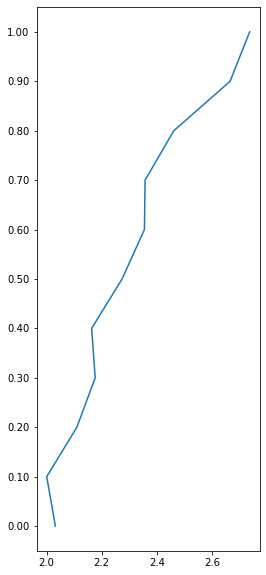

相关系数0.999
2007/10/03:08    2.303
dtype: float64


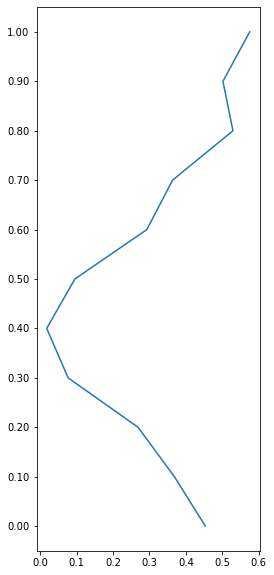

相关系数0.9997
2007/11/11:20    0.1098
dtype: float64


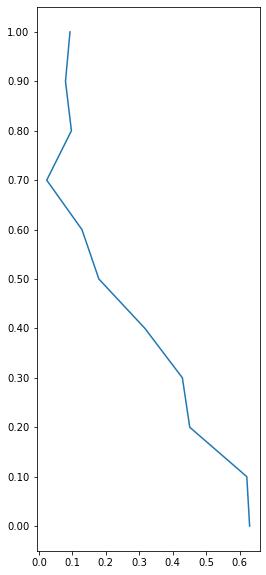

相关系数0.9998
2009/04/25:20    0.2283
dtype: float64


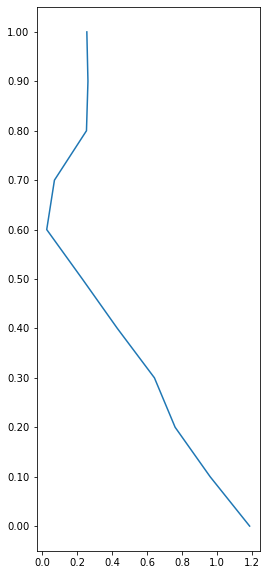

相关系数0.999
2009/04/22:20    0.3082
dtype: float64


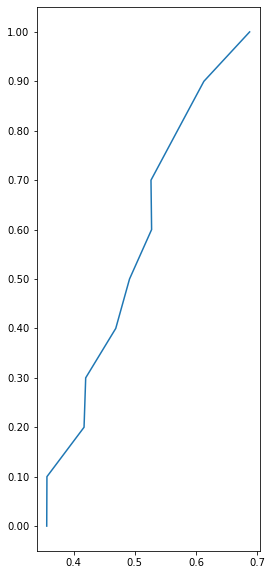

相关系数1.0
2009/05/18:20    0.4941
dtype: float64


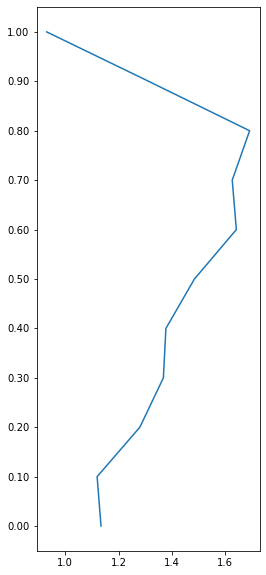

相关系数0.9936
2010/03/15:08    1.3609
dtype: float64


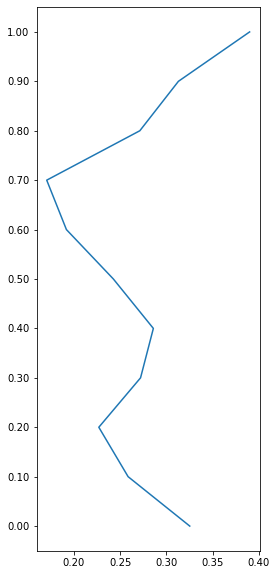

相关系数0.9993
2007/09/09:08    0.268
dtype: float64


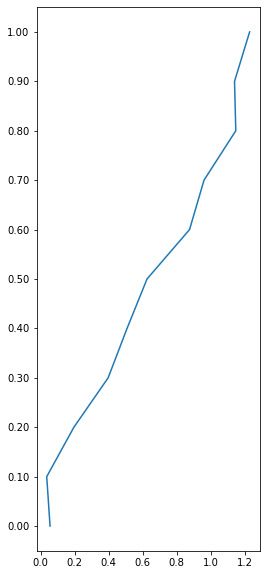

相关系数0.9995
2007/10/30:20    0.6421
dtype: float64


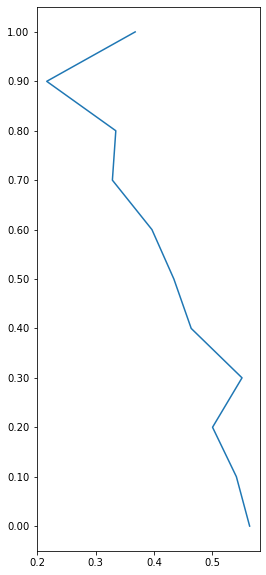

相关系数0.9996
2009/06/06:08    0.427
dtype: float64


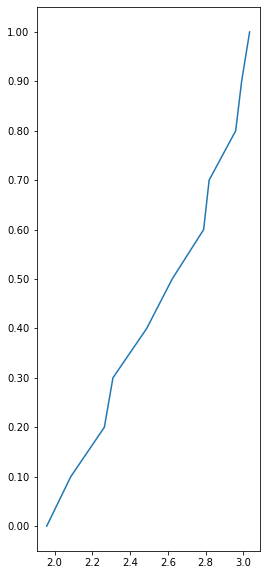

相关系数0.9996
2007/11/02:20    2.5741
dtype: float64


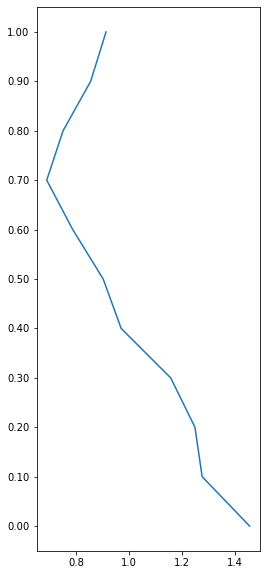

相关系数0.9953
2010/01/10:08    0.9999
dtype: float64


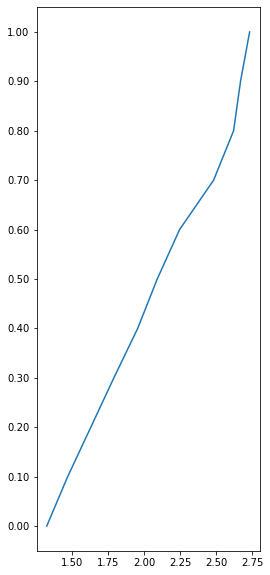

相关系数0.9997
2007/11/07:20    2.0912
dtype: float64


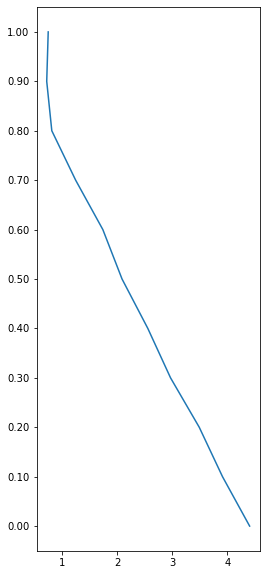

相关系数0.9924
2009/03/20:08    2.2458
dtype: float64


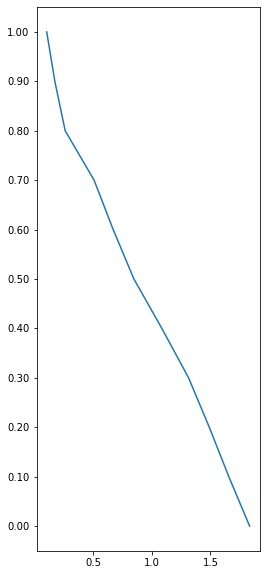

相关系数0.9995
2007/12/09:20    0.9042
dtype: float64


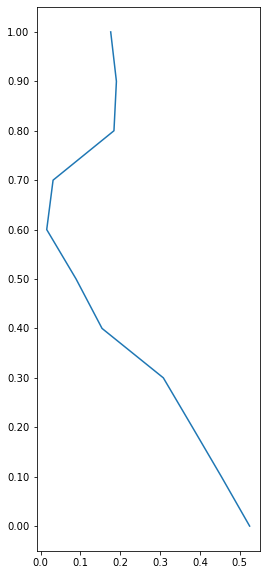

相关系数0.9997
2007/09/06:20    0.1223
dtype: float64


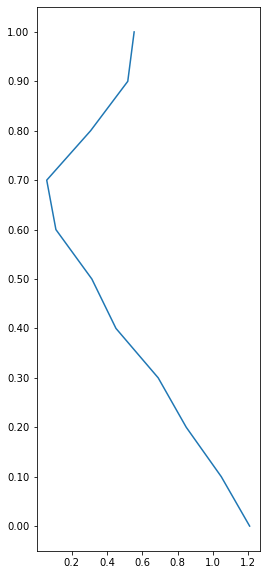

相关系数0.9992
2009/05/12:20    0.294
dtype: float64


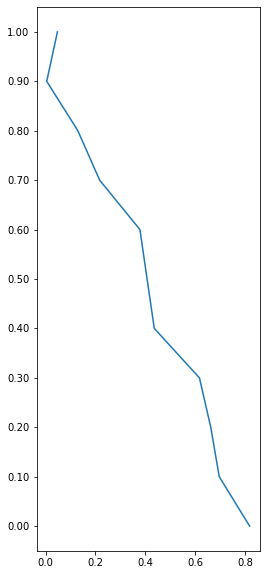

相关系数0.9998
2010/05/19:08    0.3929
dtype: float64


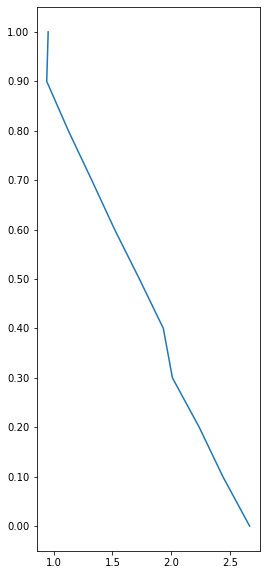

相关系数0.9997
2007/07/13:20    1.716
dtype: float64


In [14]:
for i in range(20):
    flag = random.randrange(0, 200)
    fig = plt.figure(figsize=(4, 10))
    Height = test_labels.columns
    X1 = model.predict(test_data[flag:flag + 1]).T
    X2 = test_labels[flag:flag + 1].T
    plt.plot(np.abs(X1 - X2), Height)
    # plt.plot(X1, Height)
    # plt.plot(X2, Height)
    plt.show()
    print('相关系数{:.4}'.format(np.corrcoef(X1.T, X2.T)[0, 1]))
    # print('平均偏差{:.4}'.format((X1-X2).mean().values))
    # print(np.corcoef(X1.T,X2.T))
    print(np.abs(np.mean(X1 - X2).round(4)))

In [2]:
from Extract_simulated_brightness_temperature import extract

data = extract()
data

,22.235,23.035,23.835,26.235,30.000,51.250,52.280,53.850,54.940,56.660,57.290,58.800
2007010100,9.721,9.776,9.482,8.710,7.868,7.474,7.423,7.734,65.157,77.821,96.485,123.289
2007010112,10.839,10.863,10.264,9.041,7.941,7.481,7.412,7.721,65.264,77.979,96.723,123.636
2007010200,19.714,19.823,18.726,15.860,12.654,10.937,10.038,9.986,67.832,80.307,98.676,125.049
2007010212,18.577,18.695,17.770,15.224,12.289,10.695,9.865,9.841,67.686,80.159,98.522,124.885
2007010300,14.867,14.958,14.294,12.500,10.451,9.364,8.863,8.983,66.786,79.285,97.668,124.036
...,...,...,...,...,...,...,...,...,...,...,...,...
2009122912,8.501,8.552,8.336,7.715,7.069,6.812,6.853,7.192,62.018,74.106,91.916,117.572
2009123000,9.021,9.092,8.939,8.358,7.647,7.317,7.307,7.638,65.006,77.459,95.750,121.996
2009123012,8.412,8.465,8.290,7.769,7.193,6.955,7.007,7.359,64.204,76.806,95.400,122.141
2009123100,9.799,9.819,9.315,8.316,7.449,7.119,7.135,7.481,64.761,77.341,95.863,122.466
